# All Modules Functionality Workbook

This notebook demonstrates all steps of the workflow: fetching, transforming, training, inference, and simulation.

In [1]:
import matplotlib.pyplot as plt
from scripts.data_repo import DataRepository
from scripts.transform import TransformData
from scripts.train import TrainModel
import warnings
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
# workflow settings
FETCH_REPO = False
TRANSFORM_DATA = False
TRAIN_MODEL = False

# 1) Fetching data from API / Loading from a local storage

In [3]:
repo = DataRepository()
if FETCH_REPO:
    # Fetch All 3 datasets for all dates from APIs
    repo.fetch()
    # save data to a local dir
    repo.persist(data_dir="local_data/")
else:
    # OR Load from disk
    repo.load(data_dir="local_data/")


# DEBUG: Separate fetching of the datasets (YFinance-Tickers, YFinance-Indexes, FRED-Macro)
# repo.fetch_indexes()
# repo.fetch_tickers()
# repo.fetch_macro()

In [4]:
repo.ticker_df.Date.agg({"min", "max", "count"})

max      2024-07-12
count        735098
min      1970-01-02
Name: Date, dtype: object

In [5]:
repo.ticker_df.Ticker.nunique()

87

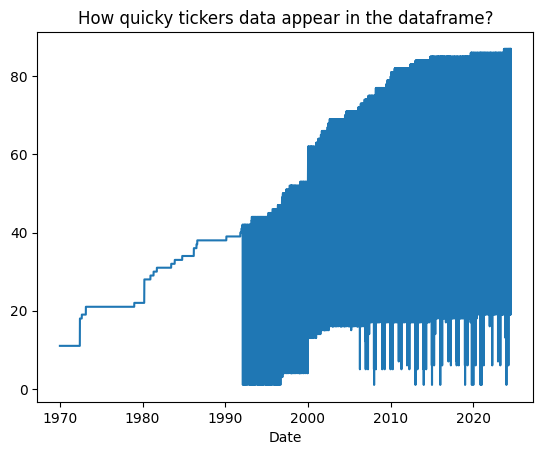

In [6]:
repo.ticker_df.groupby("Date")["Open"].agg("count").plot()
plt.title("How quicky tickers data appear in the dataframe?")
plt.show()

In [7]:
repo.indexes_df.shape

(13752, 49)

In [8]:
repo.indexes_df.tail(1)

,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,1.005517,1.00688,1.019303,1.066148,1.094407,1.379503,1.011525,1.028076,1.020335,1.013528,...,0.985738,1.016866,1.026691,1.001296,1.00967,0.998108,1.021833,0.848453,0.90721,1.839477


In [9]:
repo.macro_df.tail(1)

,DGS1,DGS5,Date,Quarter,gdppot_us_yoy,gdppot_us_qoq,Month,FEDFUNDS,cpi_core_yoy,cpi_core_mom,DGS10
DATE,,,,,,,,,,,
2024-07-11,4.91,4.13,2024-07-11,2024-07-01,0.020675,0.005201,2024-07-01,5.33,0.032769,0.000648,4.2


# 2) Transform all input fields (data_repo dfs) to one dataframe

In [10]:
transformed = TransformData(repo=repo)

if TRANSFORM_DATA:
    transformed.transform()
    transformed.persist(data_dir="local_data/")
else:
    transformed.load(data_dir="local_data/")

In [11]:
transformed.transformed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 487820 entries, 0 to 11173
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), float64(128), int32(65), int64(5), object(2)
memory usage: 638.3+ MB


In [12]:
transformed.transformed_df.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
11172,255.570007,255.570007,241.100006,241.259995,241.259995,5623800.0,US,AMAT,2024,7,...,0.986143,1.014011,1.022142,0.985460,0.993115,1.011283,1.006445,0.851674,0.853399,1.886864
11173,241.610001,248.770004,240.539993,243.399994,243.399994,5395200.0,US,AMAT,2024,7,...,0.985738,1.016866,1.026691,1.001296,1.009670,0.998108,1.021833,0.848453,0.907210,1.839477


In [13]:
# last 3 days of the data
transformed.transformed_df.tail(3)["Date"]

11171   2024-07-10 00:00:00+00:00
11172   2024-07-11 00:00:00+00:00
11173   2024-07-12 00:00:00+00:00
Name: Date, dtype: datetime64[ns, UTC]

# 3) Train the best model 
* Model : Random Forest(max_depth=17, n_estimators=200)

In [14]:
# Suppress all warnings (not recommended in production unless necessary)
warnings.filterwarnings("ignore")

trained = TrainModel(transformed=transformed)

if TRAIN_MODEL:
    trained.prepare_dataframe()  # prepare dataframes
    trained.train_random_forest()  # train the model
    trained.persist(data_dir="local_data/")  # save the model to disk
else:
    trained.prepare_dataframe()  # prepare dataframes (incl. for inference)
    trained.load(data_dir="local_data/")

Prepare the dataframe: define feature sets, add dummies, temporal split
length: X_train (329010, 295),  X_validation (79169, 295), X_test (79641, 295)
  X_train_valid = (408179, 295),  all combined: X_all (487820, 295)


In [15]:
# resulting df
trained.df_full.tail(2)

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_V,Ticker_VZ,Ticker_WFC,Ticker_WMT,Ticker_XOM,ticker_type_CAP_GAIN,ticker_type_EU,ticker_type_JAPAN,ticker_type_US,split
11172,255.570007,255.570007,241.100006,241.259995,241.259995,5623800.0,US,AMAT,2024,7,...,0,0,0,0,0,0,0,0,1,test
11173,241.610001,248.770004,240.539993,243.399994,243.399994,5395200.0,US,AMAT,2024,7,...,0,0,0,0,0,0,0,0,1,test


# 4) Inference

In [16]:
prediction_name = "pred_rf_best"
trained.make_inference(pred_name=prediction_name)

Making inference
before 0
0
before 121955
121955
before 243910
243910
before 365865
365865


In [17]:
trained.df_full

,Open,High,Low,Close,Adj Close,Volume,ticker_type,Ticker,Year,Month_x,...,Ticker_WFC,Ticker_WMT,Ticker_XOM,ticker_type_CAP_GAIN,ticker_type_EU,ticker_type_JAPAN,ticker_type_US,split,pred_rf_best,pred_rf_best_rank
0,4.030000,4.605000,4.020000,4.600000,4.209763,395343000.0,US,MA,2006,5,...,0,0,0,0,0,0,1,train,0.422924,53.0
1,4.630000,4.674000,4.411000,4.493000,4.111840,103044000.0,US,MA,2006,5,...,0,0,0,0,0,0,1,train,0.500914,43.0
2,4.497000,4.498000,4.285000,4.400000,4.026731,49898000.0,US,MA,2006,5,...,0,0,0,0,0,0,1,train,0.475185,48.0
3,4.435000,4.536000,4.435000,4.494000,4.112754,30002000.0,US,MA,2006,5,...,0,0,0,0,0,0,1,train,0.493673,41.0
4,4.493000,4.810000,4.490000,4.751000,4.347953,62344000.0,US,MA,2006,6,...,0,0,0,0,0,0,1,train,0.496038,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11169,243.110001,247.179993,243.110001,246.289993,246.289993,3782100.0,US,AMAT,2024,7,...,0,0,0,0,0,0,1,test,0.443051,67.0
11170,248.000000,252.130005,247.479996,251.470001,251.470001,4889900.0,US,AMAT,2024,7,...,0,0,0,0,0,0,1,test,0.375860,73.0
11171,253.000000,255.889999,250.660004,254.970001,254.970001,4258100.0,US,AMAT,2024,7,...,0,0,0,0,0,0,1,test,0.403878,74.0
11172,255.570007,255.570007,241.100006,241.259995,241.259995,5623800.0,US,AMAT,2024,7,...,0,0,0,0,0,0,1,test,0.397757,74.0


In [18]:
COLUMNS = ["Adj Close", "Ticker", "Date", prediction_name, prediction_name + "_rank"]
trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1].sort_values(
    by="Date"
).tail(10)[COLUMNS]

,Adj Close,Ticker,Date,pred_rf_best,pred_rf_best_rank
11165,203.710007,TM,2024-07-01 00:00:00+00:00,0.900537,1.0
11166,206.210007,TM,2024-07-02 00:00:00+00:00,0.906909,1.0
3637,24.660000,IDEXY,2024-07-03 00:00:00+00:00,0.870109,1.0
5434,4020.949951,TCS.NS,2024-07-04 00:00:00+00:00,0.849862,1.0
3752,170.330994,AVGO,2024-07-05 00:00:00+00:00,0.859494,1.0
3753,174.585999,AVGO,2024-07-08 00:00:00+00:00,0.900513,1.0
6129,3376.000000,8058.T,2024-07-09 00:00:00+00:00,0.927544,1.0
8235,68.139999,TTE,2024-07-10 00:00:00+00:00,0.887750,1.0
8236,68.410004,TTE,2024-07-11 00:00:00+00:00,0.867408,1.0
5047,253.970001,CRM,2024-07-12 00:00:00+00:00,0.931747,1.0


In [19]:
print(
    trained.df_full[trained.df_full[f"{prediction_name}_rank"] == 1]
    .sort_values(by="Date")
    .tail(10)[COLUMNS]
)

         Adj Close  Ticker                      Date  pred_rf_best  \
11165   203.710007      TM 2024-07-01 00:00:00+00:00      0.900537   
11166   206.210007      TM 2024-07-02 00:00:00+00:00      0.906909   
3637     24.660000   IDEXY 2024-07-03 00:00:00+00:00      0.870109   
5434   4020.949951  TCS.NS 2024-07-04 00:00:00+00:00      0.849862   
3752    170.330994    AVGO 2024-07-05 00:00:00+00:00      0.859494   
3753    174.585999    AVGO 2024-07-08 00:00:00+00:00      0.900513   
6129   3376.000000  8058.T 2024-07-09 00:00:00+00:00      0.927544   
8235     68.139999     TTE 2024-07-10 00:00:00+00:00      0.887750   
8236     68.410004     TTE 2024-07-11 00:00:00+00:00      0.867408   
5047    253.970001     CRM 2024-07-12 00:00:00+00:00      0.931747   

       pred_rf_best_rank  
11165                1.0  
11166                1.0  
3637                 1.0  
5434                 1.0  
3752                 1.0  
3753                 1.0  
6129                 1.0  
8235         

# 5) Simulation

In [20]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT


def get_predictions_correctness(df: pd.DataFrame, to_predict: str):
    PREDICTIONS = [k for k in df.keys() if k.startswith("pred")]
    print(f"Prediction columns founded: {PREDICTIONS}")

    # add columns is_correct_
    for pred in PREDICTIONS:
        part1 = pred.split("_")[0]  # first prefix before '_'
        df[f"is_correct_{part1}"] = (new_df[pred] == new_df[to_predict]).astype(int)

    # IS_CORRECT features set
    IS_CORRECT = [k for k in df.keys() if k.startswith("is_correct_")]
    print(f"Created columns is_correct: {IS_CORRECT}")

    print("Precision on TEST set for each prediction:")
    # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
    for i, column in enumerate(IS_CORRECT):
        prediction_column = PREDICTIONS[i]
        is_correct_column = column
        filter = (new_df.split == "test") & (new_df[prediction_column] == 1)
        print(
            f"Prediction column:{prediction_column} , is_correct_column: {is_correct_column}"
        )
        print(new_df[filter][is_correct_column].value_counts())
        print(new_df[filter][is_correct_column].value_counts() / len(new_df[filter]))
        print("---------")

    return PREDICTIONS, IS_CORRECT


new_df = trained.df_full
PREDICTIONS, IS_CORRECT = get_predictions_correctness(
    new_df, to_predict="is_positive_growth_5d_future"
)
PREDICTIONS

Prediction columns founded: ['pred_rf_best', 'pred_rf_best_rank']
Created columns is_correct: ['is_correct_pred']
Precision on TEST set for each prediction:
Prediction column:pred_rf_best , is_correct_column: is_correct_pred
Series([], Name: count, dtype: int64)
Series([], Name: count, dtype: float64)
---------


['pred_rf_best', 'pred_rf_best_rank']

In [22]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = []  # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
    print(f"Calculating sumulation for prediction {pred}:")
    print(
        f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records"
    )

    # Prefix: e.g. pred1 or pred10
    pred_prefix = pred.split("_")[0]

    # Fin. result columns: define new records for EACH positive prediction
    new_df["sim1_gross_rev_" + pred_prefix] = (
        new_df[pred] * 100 * (new_df["growth_future_5d"] - 1)
    )
    new_df["sim1_fees_" + pred_prefix] = -new_df[pred] * 100 * 0.002
    new_df["sim1_net_rev_" + pred_prefix] = (
        new_df["sim1_gross_rev_" + pred_prefix] + new_df["sim1_fees_" + pred_prefix]
    )

    # calculate agg. results for each PREDICTION columns (pred) on TEST
    filter_test_and_positive_pred = (
        (new_df.split == "test") & (new_df[pred] == 1)
    )  # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
    sim1_count_investments = len(new_df[filter_test_and_positive_pred])
    sim1_gross_rev = new_df[filter_test_and_positive_pred][
        "sim1_gross_rev_" + pred_prefix
    ].sum()
    sim1_fees = new_df[filter_test_and_positive_pred]["sim1_fees_" + pred_prefix].sum()
    sim1_net_rev = new_df[filter_test_and_positive_pred][
        "sim1_net_rev_" + pred_prefix
    ].sum()

    if sim1_gross_rev > 0:
        sim1_fees_percentage = -sim1_fees / sim1_gross_rev
    else:
        sim1_fees_percentage = None

    if sim1_count_investments > 0:
        sim1_average_net_revenue = sim1_net_rev / sim1_count_investments
    else:
        sim1_average_net_revenue = None

    # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
    df_investments_count_daily = pd.DataFrame(
        new_df[filter_test_and_positive_pred].groupby("Date")[pred].count()
    )
    sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
    sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(
        0.75
    )  # 75% case - how many $100 investments per day do we have?
    # df_investments_count_daily[pred].mean()
    sim1_capital = (
        100 * 5 * sim1_q75_investments_per_day
    )  # 5 days in a row with positive predictions
    # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
    sim1_CAGR = ((sim1_capital + sim1_net_rev) / sim1_capital) ** (1 / 4)

    # append to DF
    sim1_results.append(
        (
            pred,
            sim1_count_investments,
            sim1_gross_rev,
            sim1_fees,
            sim1_net_rev,
            sim1_fees_percentage,
            sim1_average_net_revenue,
            sim1_avg_investments_per_day,
            sim1_capital,
            sim1_CAGR,
        )
    )

    # output for all predictions with some positive predictions
    if sim1_count_investments > 1:
        print(
            f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}"
        )
        print(
            f"        Count Investments in 4 years (on TEST): {sim1_count_investments}"
        )
        print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
        print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
        print(f"        Net Revenue: ${int(sim1_net_rev)}")
        print(
            f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue"
        )
        print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
        print(
            f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)"
        )

        print(
            f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% "
        )

        print("        Average daily stats: ")
        print(
            f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} "
        )
        print(
            f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} "
        )
        print(
            f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} "
        )
        print("=============================================+")


# results in a DataFrame from an Array
columns_simulation = [
    "prediction",
    "sim1_count_investments",
    "sim1_gross_rev",
    "sim1_fees",
    "sim1_net_rev",
    "sim1_fees_percentage",
    "sim1_average_net_revenue",
    "sim1_avg_investments_per_day",
    "sim1_capital",
    "sim1_CAGR",
]

df_sim1_results = pd.DataFrame(sim1_results, columns=columns_simulation)
df_sim1_results["sim1_growth_capital_4y"] = (
    df_sim1_results.sim1_net_rev + df_sim1_results.sim1_capital
) / df_sim1_results.sim1_capital
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x="sim1_avg_investments_per_day",
    y="sim1_CAGR",
    size="sim1_growth_capital_4y",  # Use the 'size' parameter for sim1_CAGR
    text="prediction",
    title="Compound Annual Growth vs. Time spent (Average investments per day)",
    labels={
        "sim1_capital": "Initial Capital Requirement",
        "growth_capital_4y": "4-Year Capital Growth",
    },
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition="top center")

# Show the plot
fig.show()

Calculating sumulation for prediction pred_rf_best:
    Count times of investment 0 out of 79641 TEST records
Calculating sumulation for prediction pred_rf_best_rank:
    Count times of investment 961 out of 79641 TEST records
    Financial Result: 
 sim1_gross_rev_pred    315.293029
sim1_fees_pred        -192.200000
sim1_net_rev_pred      124.093029
dtype: float64
        Count Investments in 4 years (on TEST): 961
        Gross Revenue: $315
        Fees (0.2% for buy+sell): $192
        Net Revenue: $124
        Fees are 60 % from Gross Revenue
        Capital Required : $500 (Vbegin)
        Final value (Vbegin + Net_revenue) : $624 (Vfinal)
        Average CAGR on TEST (4 years) : 1.057, or 5.7% 
        Average daily stats: 
            Average net revenue per investment: $0.13 
            Average investments per day: 1 
            Q75 investments per day: 1 
=============================================+
